<h1 align="center">Credit Fraud Detector</h1>

<h2>Gather Sense of Our Data:</h2>

The first thing we must do is gather a **basic sense** of our data. Remember, except for the **transaction**
and **amount** we don't know what the other columns are (due to privacy reasons). The only thing we 
know, is that those columns that are unknown have been scaled already.

In [101]:
# import base libraries
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# import others
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

# import warning
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import warnings as sklearnwarings
sklearnwarings.filterwarnings('ignore')

# set style
plt.style.use("dark_background")

<h2>Load dataset</h2>

In [102]:
# set option view of pandas
pd.set_option("display.max_columns",100)

In [103]:
# load credit card dataset
url = "https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download"
downloaded = "/Users/nguyens/Downloads/creditcard.csv"
data = pd.read_csv(downloaded)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h2>Explore Data Analysis</h2>

we have **time** columns and **amount** columns. Let get a distribution of them.

Check null data

In [104]:
data.isnull().sum().max()

0

Dataset has no Nan values. That's great baseline to work with.

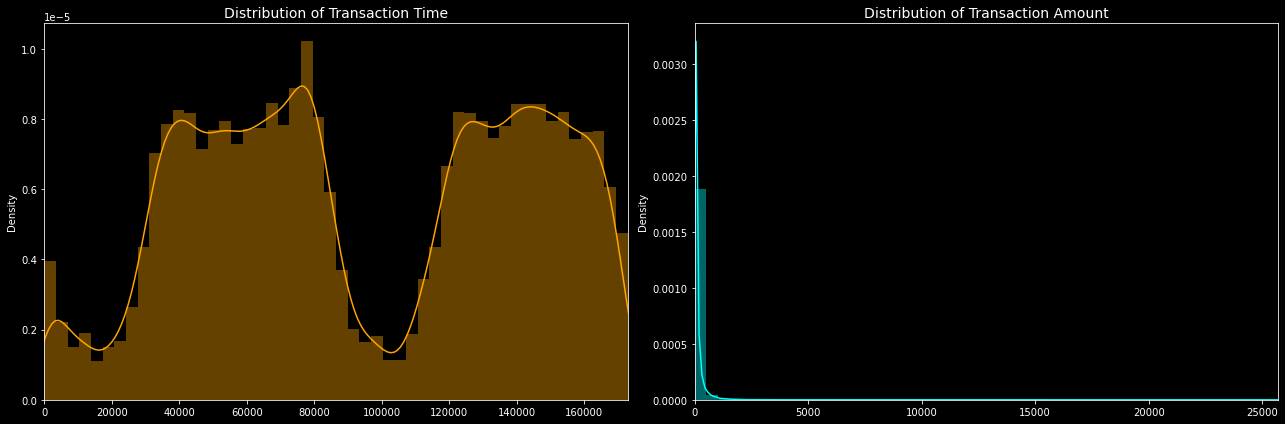

In [105]:
# set params
time_val = data["Time"].values
amounts_val = data["Amount"].values

title = ["Distribution of Transaction Time", "Distribution of Transaction Amount"]
# plot
fig, axes = plt.subplots(1, 2, figsize=(18,6))

# time
sns.distplot(time_val, ax=axes[0], color="orange")
axes[0].set_title("Distribution of Transaction Time", fontsize=14)
axes[0].set_xlim([min(time_val), max(time_val)])
#axes[0].set_ylim([0, len(time_val)])

# amount
sns.distplot(amounts_val, ax=axes[1], color="cyan")
axes[1].set_title("Distribution of Transaction Amount", fontsize=14)
axes[1].set_xlim([min(amounts_val), max(amounts_val)])
#axes[1].set_ylim([0, len(amounts_val)])

plt.tight_layout()
#plt.show()


Check class imbalance:

In [106]:
# print out the percentage of each class
print(f"Frauds percentage in dataset: {data.Class.mean():%}")

Frauds percentage in dataset: 0.172749%


The dataset is highly imbalanced. Only *0.173%* of class is class 1 (fraud).

Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1: Fraud)')

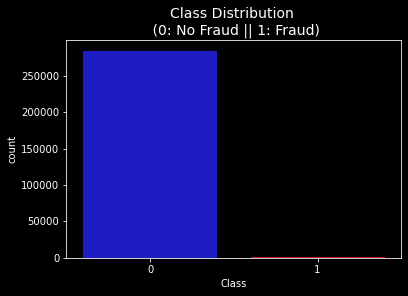

In [107]:
# plot the distribution
colors = ["#0101DF", "#DF0101"]
sns.countplot("Class", data=data, palette=colors)
plt.title("Class Distribution \n (0: No Fraud || 1: Fraud)", fontsize=14)


**Distributions**: By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

**Scaling and Distribution**

Let's check the summarize of dataset:

In [108]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We see that only *Time* and *Amount* have a different range with other. So it's a good idea to scale two features
to have a same range with others.

On the other hand, we need to also create a sub-sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, 
helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

**What is a sub-Sample?**

In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

**Why do we create a sub-Sample?**

In the beginning of this notebook we saw that the original dataframe was heavily imbalanced! Using the original dataframe will cause the following issues:

- Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
- Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

Summary:

- Scaled amount and scaled time are the columns with scaled values.
- There are 492 cases of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe.
- We concat the 492 cases of fraud and non fraud, creating a new sub-sample.

In [109]:
# scale data
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rbs_scaler = RobustScaler()

# scale
data["scaled_amount"] = rbs_scaler.fit_transform(data["Amount"].values.reshape(-1,1))

data["scaled_time"] = rbs_scaler.fit_transform(data["Time"].values.reshape(-1,1))

# drop original columns
data.drop(columns=["Time", "Amount"], inplace=True)


In [110]:
# Rearange columns
columns = ["scaled_time", "scaled_amount"] + [col for col in data.columns if col not in ["scaled_time", "scaled_amount"]]

data = data[columns]
data.head()


,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


**Split data**

In [111]:
# Fraud and Non-Fraud of original dataset
print(f"Fraud percentage: {data.Class.mean(): %}")
print(f"No-Fraud percentage: {(1-data.Class.mean()): %}")

# set X and y
X = data.drop(columns="Class")
y = data["Class"]

# split
skfolds = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# loop to split
for train_index, test_index in skfolds.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
    original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]

# We already have X_train, y_train for undersample data thats why I am using original to distinguish
# and to not overwrite these variables:
# original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn into an array
original_Xtrain = original_X_train.values
original_Xtest = original_X_test.values
original_ytrain = original_y_train.values
original_ytest = original_y_test.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


Fraud percentage:  0.172749%
No-Fraud percentage:  99.827251%
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


**Random Under-Sampling:**

In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:
- The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
- Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.
- After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)

In [112]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Let shuffle the data before creating the subsamples
data = data.sample(frac=1)

# amount of fraud classes is 492 rows
fraud_data = data[data["Class"] == 1]
non_fraud_data = data[data["Class"] == 0][:492]

# distribution
normal_distributed_data = pd.concat([fraud_data, non_fraud_data], axis=0)

# shuffle data
new_data = normal_distributed_data.sample(frac=1, random_state=42)

new_data.head()


,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
229383,0.719099,0.511982,-0.503309,0.817289,-0.096398,-0.761049,1.600113,1.012942,1.073294,0.354037,-0.665872,-1.250477,1.107202,0.403074,-0.346707,-0.747456,-0.159090,-0.214201,0.901666,-0.721451,-0.773331,-0.067121,-0.143320,-0.393415,0.029250,-1.757035,-0.510763,0.084788,0.127572,0.151796,0
14197,-0.698563,1.089779,-16.598665,10.541751,-19.818982,6.017295,-13.025901,-4.128779,-14.118865,11.161144,-4.099551,-9.222826,6.329365,-8.952191,-0.138364,-9.825054,0.057224,-7.541687,-14.259599,-5.035052,1.432268,1.534920,1.725853,-1.151606,-0.680052,0.108176,1.066878,-0.233720,1.707521,0.511423,1
170364,0.416534,1.620066,1.733917,-0.750201,-0.556185,0.244296,-0.586897,-0.250725,-0.331461,-0.017567,0.676160,0.091097,0.756202,1.336345,0.749533,0.024131,-0.217822,0.686076,-0.895768,0.040414,0.327981,0.134733,-0.146060,-0.614196,0.268589,-0.323654,-0.661148,0.216863,-0.063889,-0.032937,0
178208,0.456220,0.328513,-5.904921,4.439911,-8.631802,7.788684,-4.989580,-1.200144,-7.674060,4.125761,-5.315778,-4.891156,4.220419,-6.408301,1.328003,-5.853545,-0.928337,-7.085798,-12.623856,-4.745224,2.797892,-0.505608,1.775030,1.266441,-0.199410,0.014960,-0.000019,0.544210,-1.167566,-1.206354,1
93486,-0.237890,-0.307413,1.079524,0.872988,-0.303850,2.755369,0.301688,-0.350284,-0.042848,0.246625,-0.779176,-0.157696,1.928568,-0.935863,-2.431446,-1.633472,0.534337,1.425606,1.593529,1.178468,-1.568698,-0.252115,-0.023255,-0.158601,-0.038806,-0.060327,0.358339,0.076984,0.018936,0.060574,1


**Equally Distributing and Correlating**:

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


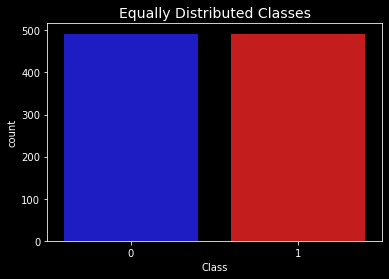

In [113]:
# print out ratio of each class in dataset
print("Distribution of the Classes in the subsample dataset")
print(new_data["Class"].value_counts()/len(new_data))

# plot
sns.countplot("Class", data=new_data, palette=colors)
plt.title("Equally Distributed Classes", fontsize=14)
plt.show()


**Correlation Matrices**

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

**Summary and Explanation**:

- Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
- Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.
- BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

Note: We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

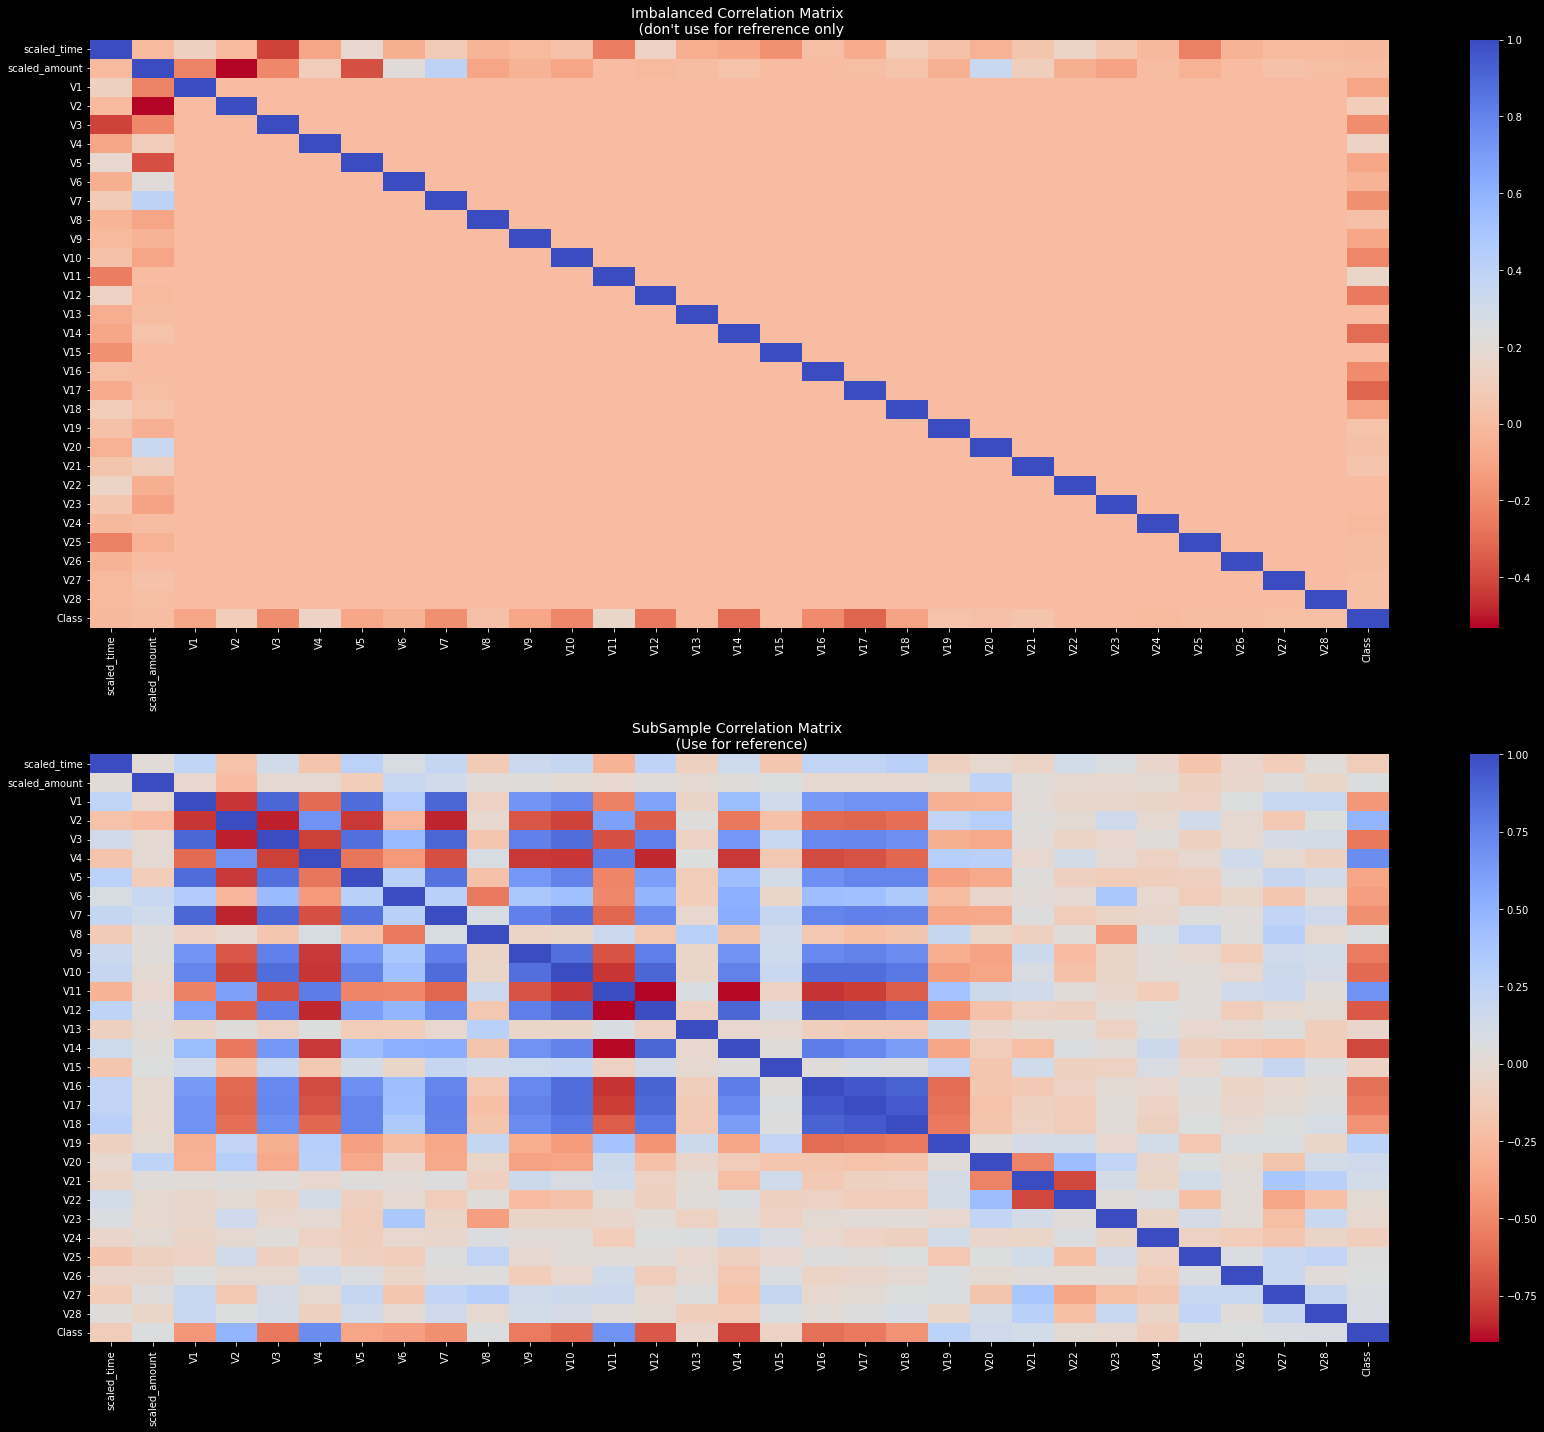

In [114]:
# correlation matrix
cor_data = data.corr(method="pearson")
cor_sub = new_data.corr(method='pearson')

# heatmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

## entire dataset
sns.heatmap(data=cor_data, cmap="coolwarm_r", annot_kws={"size":20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for refrerence only", fontsize=14)

## subsample
sns.heatmap(data=cor_sub, cmap="coolwarm_r", annot_kws={"size": 20}, ax=ax2)
ax2.set_title("SubSample Correlation Matrix \n (Use for reference)", fontsize=14)

plt.tight_layout()


**Boxplot**:

Text(0.5, 1.0, 'V10 vs Class Negative Correlation')

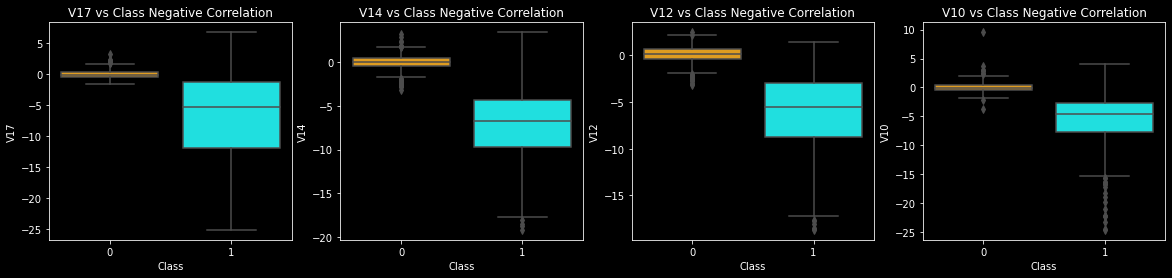

In [115]:
# set colors
colors = ["orange", "cyan"]

# create subplots
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# boxplot negative correlation features
sns.boxplot(x="Class", y="V17", data=new_data, palette=colors, ax=axes[0])
axes[0].set_title("V17 vs Class Negative Correlation")

sns.boxplot(x="Class", y="V14", data=new_data, palette=colors, ax=axes[1])
axes[1].set_title("V14 vs Class Negative Correlation")

sns.boxplot(x="Class", y="V12", data=new_data, palette=colors, ax=axes[2])
axes[2].set_title("V12 vs Class Negative Correlation")

sns.boxplot(x="Class", y="V10", data=new_data, palette=colors, ax=axes[3])
axes[3].set_title("V10 vs Class Negative Correlation")


**Boxplot for positive class**:

Text(0.5, 1.0, 'V2 vs Class Negative Correlation')

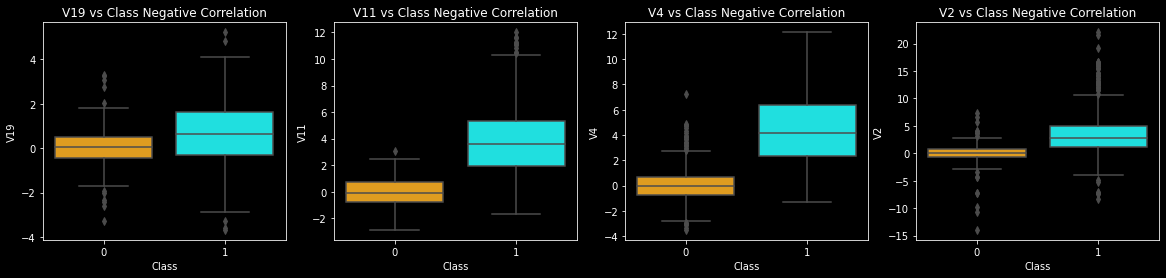

In [116]:
# set colors
colors = ["orange", "cyan"]

# create subplots
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# boxplot negative correlation features
sns.boxplot(x="Class", y="V19", data=new_data, palette=colors, ax=axes[0])
axes[0].set_title("V19 vs Class Negative Correlation")

sns.boxplot(x="Class", y="V11", data=new_data, palette=colors, ax=axes[1])
axes[1].set_title("V11 vs Class Negative Correlation")

sns.boxplot(x="Class", y="V4", data=new_data, palette=colors, ax=axes[2])
axes[2].set_title("V4 vs Class Negative Correlation")

sns.boxplot(x="Class", y="V2", data=new_data, palette=colors, ax=axes[3])
axes[3].set_title("V2 vs Class Negative Correlation")


**Anomaly Detection:**

Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models. 

Interquartile Range Method:

- Interquartile Range (IQR): We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.
- Boxplots: Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme).

**Outlier Removal Tradeoff**:

We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect. 

**The Tradeoff**: The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

**Summary**:

- Visualize Distributions: We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10.
- Determining the threshold: After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold).
- Conditional Dropping: Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed.
- Boxplot Representation: Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount.

**Note**: After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.



**Positive features**:

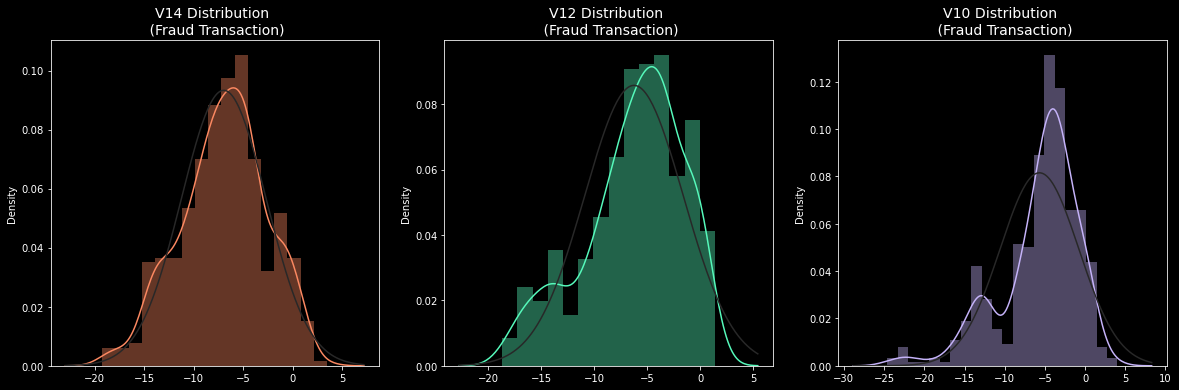

In [117]:
from scipy.stats import norm
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

v14_fraud_dist = new_data["V14"].loc[new_data["Class"]==1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color="#FB8861")
ax1.set_title("V14 Distribution \n (Fraud Transaction)", fontsize=14)

v12_fraud_dist = new_data["V12"].loc[new_data["Class"]==1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color="#56F9BB")
ax2.set_title("V12 Distribution \n (Fraud Transaction)", fontsize=14)

v10_fraud_dist = new_data["V10"].loc[new_data["Class"]==1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color="#C5B3F9")
ax3.set_title("V10 Distribution \n (Fraud Transaction)", fontsize=14)

plt.show()


**Removing Outliers**:

In [118]:
# Remove outliers function
def outlier_remove(new_data, outliers_features, label):
    for feature in outliers_features:
        v_fraud = new_data[feature].loc[new_data[label] == 1].values
        q_25, q_75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
        print("Quartile 25: {} | Quartile 75: {}".format(q_25, q_75))
        print("IQR: {}".format(q_75 - q_25))

        # feature cut off
        _cut_off = (q_75 - q_25) * 2
        _lower, _upper = q_25 - _cut_off, q_75 + _cut_off
        print("Cut off: {}".format(_cut_off))
        print("Lower bound: {}".format(_lower))
        print("Upper bound: {}".format(_upper))

        # outliers
        outliers = [x for x in v_fraud if x < _lower or x > _upper]
        print("Feature {} Outliers for Fraud Casses: {}".format(feature, len(outliers)))
        print("{} outliers: {}".format(feature, outliers))

        # create a new data
        new_data_ro = new_data.drop(new_data[(new_data[feature] >_upper) | (new_data[feature] < _lower)].index)
        print("===============" * 5)

    return new_data_ro

In [119]:
outliers_features = ["V14", "V12", "V10"]
label = "Class"
non_outliers_data = outlier_remove(new_data, outliers_features, label)
print('Number of Instances after outliers removal: {}'.format(len(non_outliers_data)))


Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
IQR: 5.409902115485521
Cut off: 10.819804230971043
Lower bound: -20.512527195943427
Upper bound: 6.536983381484178
Feature V14 Outliers for Fraud Casses: 0
V14 outliers: []
Quartile 25: -8.688176521812306 | Quartile 75: -2.97408802538493
IQR: 5.714088496427376
Cut off: 11.428176992854752
Lower bound: -20.116353514667058
Upper bound: 8.454088967469822
Feature V12 Outliers for Fraud Casses: 0
V12 outliers: []
Quartile 25: -7.7566982278474725 | Quartile 75: -2.6141839131895623
IQR: 5.142514314657911
Cut off: 10.285028629315821
Lower bound: -18.041726857163294
Upper bound: 7.670844716126259
Feature V10 Outliers for Fraud Casses: 11
V10 outliers: [-22.1870885620007, -18.2711681738888, -18.9132433348732, -24.4031849699728, -23.2282548357516, -22.1870885620007, -22.1870885620007, -20.9491915543611, -22.1870885620007, -19.836148851696, -24.5882624372475]
Number of Instances after outliers removal: 972


Replot data distribution using distplot and boxplot:

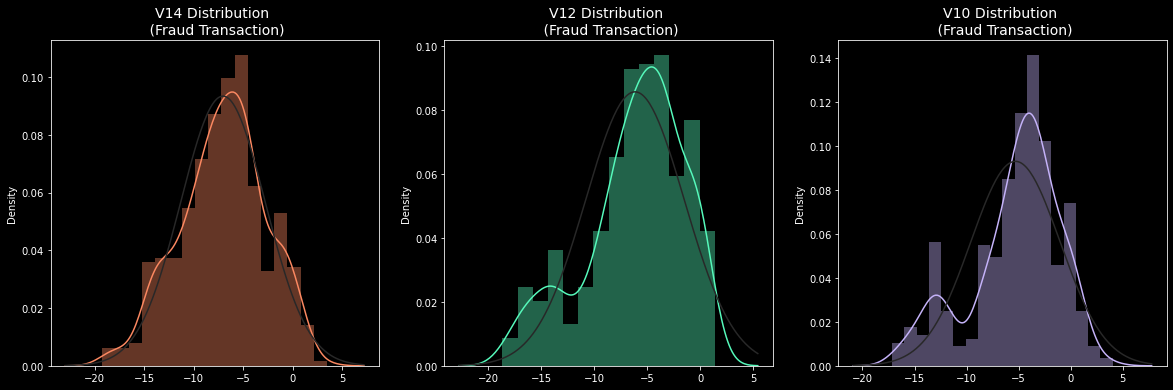

In [120]:
from scipy.stats import norm
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

v14_fraud_dist = non_outliers_data["V14"].loc[new_data["Class"]==1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color="#FB8861")
ax1.set_title("V14 Distribution \n (Fraud Transaction)", fontsize=14)

v12_fraud_dist = non_outliers_data["V12"].loc[new_data["Class"]==1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color="#56F9BB")
ax2.set_title("V12 Distribution \n (Fraud Transaction)", fontsize=14)

v10_fraud_dist = non_outliers_data["V10"].loc[new_data["Class"]==1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color="#C5B3F9")
ax3.set_title("V10 Distribution \n (Fraud Transaction)", fontsize=14)

plt.show()


Text(0, -12, 'Fewer extreme \n outliers')

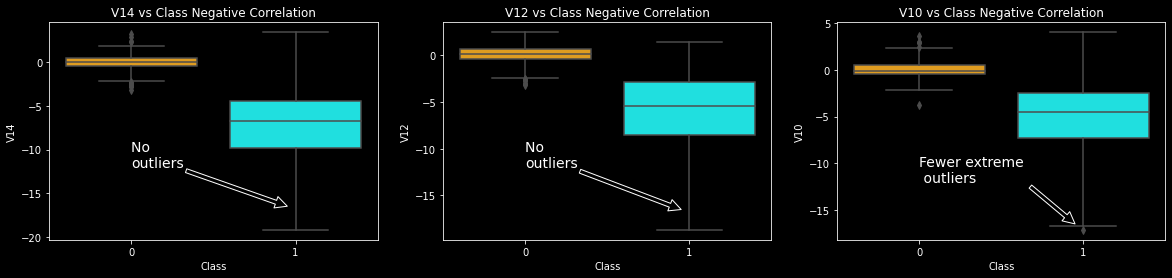

In [121]:
# set colors
colors = ["orange", "cyan"]

# create subplots
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# boxplot negative correlation features
sns.boxplot(x="Class", y="V14", data=non_outliers_data, palette=colors, ax=axes[0], whis=2)
axes[0].set_title("V14 vs Class Negative Correlation")
axes[0].annotate('No \noutliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

sns.boxplot(x="Class", y="V12", data=non_outliers_data, palette=colors, ax=axes[1], whis=2)
axes[1].set_title("V12 vs Class Negative Correlation")
axes[1].annotate('No \noutliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

sns.boxplot(x="Class", y="V10", data=non_outliers_data, palette=colors, ax=axes[2], whis=2)
axes[2].set_title("V10 vs Class Negative Correlation")
axes[2].annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


**Dimensionality Reduction and Clustering**:

*Understanding t-SNE*:

In order to understand this algorithm, we have to understand the following terms:
- Euclidean Distance
- Conditional Probability
- Normal and T-Distribution Plots

*Summary*:
- t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset.
- Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)
- This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases.

In [122]:
X.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [123]:
from sklearn.decomposition import TruncatedSVD
# create X, and y
X = non_outliers_data.drop(columns="Class")
y = non_outliers_data["Class"]

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
print("T-SNE took {:.2f} s".format(time.time() - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
print("PCA took {:.2f} s".format(time.time() - t0))

# T-SNE Implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm="randomized", random_state=42).fit_transform(X.values)
print("TruncatedSVD took {:.2f} s".format(time.time() - t0))


T-SNE took 2.24 s
PCA took 0.00 s
TruncatedSVD took 0.00 s


**Plot decomposition method**

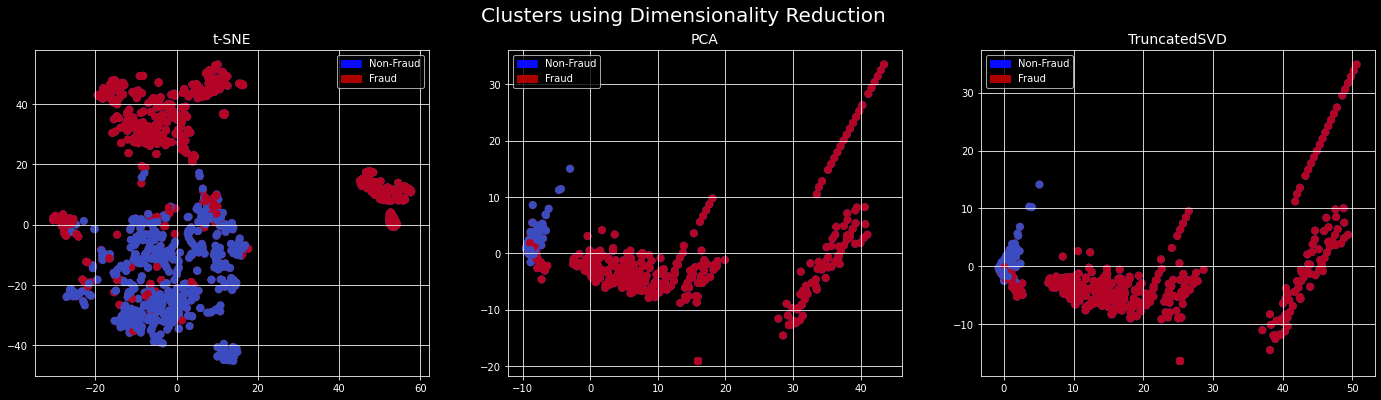

In [124]:
# create subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
fig.suptitle("Clusters using Dimensionality Reduction", fontsize=20)

# set color
blue_patch = mpatches.Patch(color="#0A0AFF", label="Non-Fraud")
red_patch = mpatches.Patch(color="#AF0000", label="Fraud")

# plot T-SNE
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y==0), cmap="coolwarm", label="Non-Fraud", linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y==1), cmap="coolwarm", label="Fraud", linewidths=2)
ax1.set_title("t-SNE", fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# plot T-SNE
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y==0), cmap="coolwarm", label="Non-Fraud", linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y==1), cmap="coolwarm", label="Fraud", linewidths=2)
ax2.set_title("PCA", fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# plot T-SNE
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y==0), cmap="coolwarm", label="Non-Fraud", linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y==1), cmap="coolwarm", label="Fraud", linewidths=2)
ax3.set_title("TruncatedSVD", fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h2>Modeling</h2>
<h3>Classifiers (UnderSampling)</h3>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting fraud transactions. Before we have to split our data into training and testing sets and separate the features from the labels.


**Split data for classifiers**

In [129]:
# Undersampling
X = non_outliers_data.drop(columns="Class")
y = non_outliers_data["Class"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
}

# apply cross validation
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
kfolds = StratifiedKFold(n_splits=5)

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(
        estimator=classifier, 
        X = X_train, 
        y=y_train, 
        cv=kfolds, 
        scoring="accuracy",
    )
    
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2)*100, "% accuracy score")


Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 92.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 93.0 % accuracy score


**Optimize Logistic Regression**

In [133]:
# Optimize for logistic regression
from sklearn.model_selection import GridSearchCV

# define params
log_reg_params = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, .1, .5, 1, 5, 10, 50, 100, 500],
}

# define randomnized search
grid_log_reg = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid=log_reg_params, 
    scoring="accuracy",
)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

print("Best score: {:.2f}".format(grid_log_reg.best_score_))
print("Best params: {}".format(grid_log_reg.best_params_))


Best score: 0.94
Best params: {'C': 1, 'penalty': 'l2'}


**Optimize KNN**

In [138]:
# Optimize for KNN
from sklearn.model_selection import GridSearchCV

# define params
knn_reg_params = {
    "n_neighbors": list(range(2, 10, 1)),
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

# define randomnized search
grid_knn_reg = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=knn_reg_params, 
    scoring="accuracy",
)
grid_knn_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
knn_reg = grid_knn_reg.best_estimator_

print("Best score: {:.2f}".format(grid_knn_reg.best_score_))
print("Best params: {}".format(grid_knn_reg.best_params_))


Best score: 0.93
Best params: {'algorithm': 'auto', 'n_neighbors': 3}


In [137]:
# Optimize for KNN
from sklearn.model_selection import GridSearchCV

# define params
svc_reg_params = {
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
    "C": np.random.uniform(0.01, 10, 50),

}

# define randomnized search
grid_svc_reg = GridSearchCV(
    estimator=SVC(class_weight="balanced"), 
    param_grid=svc_reg_params, 
    scoring="accuracy",
)
grid_svc_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
svc_reg = grid_svc_reg.best_estimator_

print("Best score: {:.2f}".format(grid_svc_reg.best_score_))
print("Best params: {}".format(grid_svc_reg.best_params_))


Best score: 0.94
Best params: {'C': 0.2500760460760057, 'kernel': 'linear'}


In [139]:
# Optimize for KNN
from sklearn.model_selection import GridSearchCV

# define params
rf_reg_params = {
    "n_estimators": np.arange(100, 200, 10),
    "min_samples_split": np.random.uniform(0.01, 1, 10),
    "min_samples_leaf": np.arange(2, 10, 1),
    "criterion": ["gini", "entropy"],

}

# define randomnized search
grid_rf_reg = GridSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced"), 
    param_grid=rf_reg_params, 
    scoring="accuracy",
)
grid_rf_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
rf_reg = grid_rf_reg.best_estimator_

print("Best score: {:.2f}".format(grid_rf_reg.best_score_))
print("Best params: {}".format(grid_rf_reg.best_params_))


Best score: 0.94
Best params: {'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 0.06825790929362797, 'n_estimators': 130}


Overfitting Cases

In [142]:
# Using the crossvalidation method to check if the model has been overfitted or not
# logistic regression
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=kfolds)
print("LogisticRegression Cross Validation Score: ", round(log_reg_score.mean(), 3))

# knn regression
knn_reg_score = cross_val_score(knn_reg, X_train, y_train, cv=kfolds)
print("Kneighbour Cross Validation Score: ", round(knn_reg_score.mean(), 3))

# svc regression
svc_reg_score = cross_val_score(svc_reg, X_train, y_train, cv=kfolds)
print("Support Vector Machine Cross Validation Score: ", round(svc_reg_score.mean(), 3))

# radomforest regression
rf_reg_score = cross_val_score(rf_reg, X_train, y_train, cv=kfolds)
print("Random Forest Cross Validation Score: ", round(rf_reg_score.mean(), 3))

LogisticRegression Cross Validation Score:  0.937
Kneighbour Cross Validation Score:  0.931
Support Vector Machine Cross Validation Score:  0.938
Random Forest Cross Validation Score:  0.933


Plot learning curve of 4 methods:

In [169]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve


# Logistic regression
def plot_learning_curve(estimators, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    fig, axes = plt.subplots(nrows=1, ncols=len(estimators), figsize=(12,4), sharey=True)
    if ylim:
        plt.ylim(*ylim)
    
    # estimator
    for i, estimator in enumerate(estimators):
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = train_scores.mean(axis=1)
        train_scores_std = train_scores.std(axis=1)
        test_scores_mean = test_scores.mean(axis=1)
        test_scores_std = test_scores.std(axis=1)
        axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                                train_scores_mean + train_scores_std, alpha=0.1, color="cyan")
        axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std, 
                                test_scores_mean + test_scores_std, alpha=0.1, color="yellow")
        axes[i].plot(train_sizes, train_scores_mean, 'o-', color = "cyan", label="Training score")
        axes[i].plot(train_sizes, test_scores_mean, 'o-', color="yellow", label="Cross-Validation score")
        axes[i].set_title(f"{str(estimator).split('(')[0]} Learning Curve", fontsize=14)
        axes[i].set_xlabel("Training size (m)")
        axes[i].set_ylabel("Score")
        axes[i].grid(True)
        axes[i].legend(loc="best")


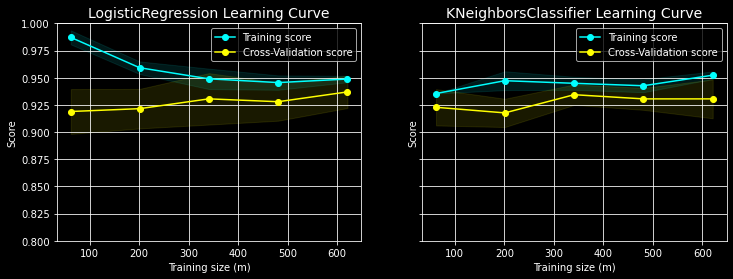

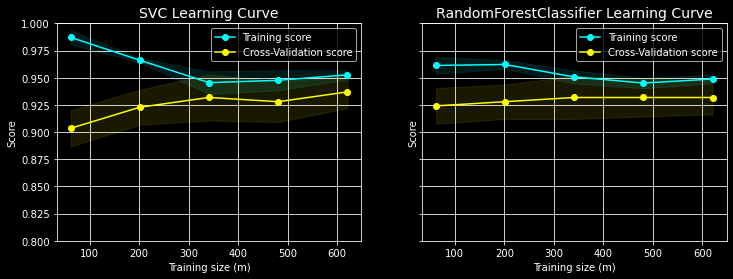

In [170]:
estimators_1 = [log_reg, knn_reg]
estimators_2 = [svc_reg, rf_reg]
plot_learning_curve(estimators_1, X_train, y_train, ylim=[0.8, 1.], cv=kfolds)
plot_learning_curve(estimators_2, X_train, y_train, ylim=[0.8, 1.], cv=kfolds)

ROC_AUC_SCORE

In [173]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

# perform prediction
log_preds = cross_val_predict(log_reg, X_test, y_test, cv=3, method="decision_function")

knn_preds = cross_val_predict(knn_reg, X_test, y_test, cv=3)

svc_preds = cross_val_predict(svc_reg, X_test, y_test, cv=3, method="decision_function")

rf_preds = cross_val_predict(rf_reg, X_test, y_test, cv=3)

# Print out
print('Logistic Regression: ', roc_auc_score(y_test, log_preds))
print('KNears Neighbors: ', roc_auc_score(y_test, knn_preds))
print('Support Vector Classifier: ', roc_auc_score(y_test, svc_preds))
print('Random Forest Classifier: ', roc_auc_score(y_test, rf_preds))


Logistic Regression:  0.9610595187842972
KNears Neighbors:  0.9402173913043479
Support Vector Classifier:  0.9665470662726889
Random Forest Classifier:  0.9196390882228789


ROC_CURVE

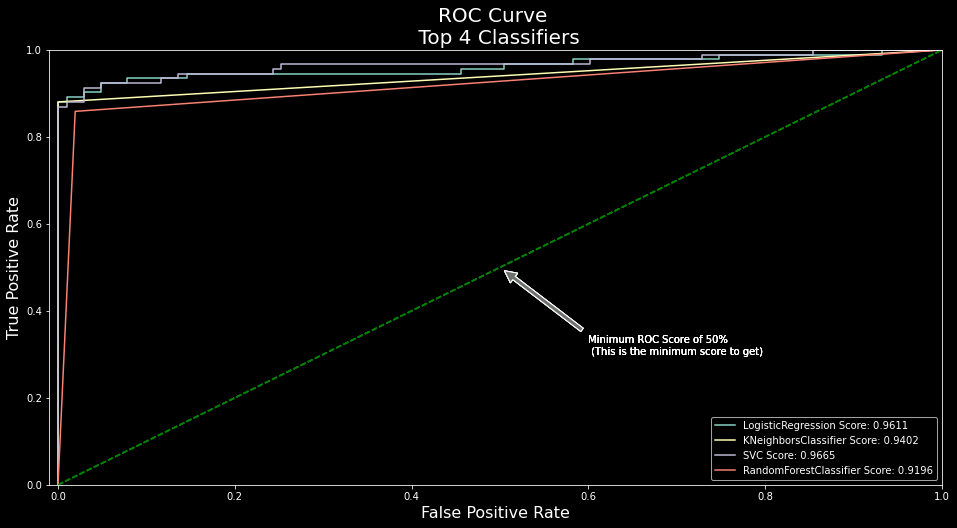

In [180]:
# estimators
estimators = [log_reg, knn_reg, svc_reg, rf_reg]

# scores
scores = [
    roc_auc_score(y_test, log_preds),
    roc_auc_score(y_test, knn_preds),
    roc_auc_score(y_test, svc_preds),
    roc_auc_score(y_test, rf_preds),
]

# Plot roc curve
log_fpr, log_tpr, log_threshold = roc_curve(y_test, log_preds)
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_test, knn_preds)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_preds)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_preds)

fprs = [log_fpr, knn_fpr, svc_fpr, rf_fpr]
tprs = [log_tpr, knn_tpr, svc_tpr, rf_tpr]

# plot
def plot_roc_curve_multiple(estimators, scores, fprs, tprs):
    plt.figure(figsize=(16,8))
    plt.title("ROC Curve \n Top 4 Classifiers", fontsize=20)
    for estimator, score,fpr, tpr in zip(estimators, scores, fprs, tprs):
        plt.plot(fpr, tpr, label=f"{str(estimator).split('(')[0]} Score: {score:.4f}")
        plt.plot([0, 1], [0, 1], 'g--')
        plt.axis([-0.01, 1, 0, 1])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
        plt.legend()

# call function
plot_roc_curve_multiple(estimators, scores, fprs, tprs)

<h4>Summary</h4>

- Logistic Regression classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)
- GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.
- Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.

<h4>Learning Curves</h4>

- The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
- Logistic Regression Classifier shows the best score in both training and cross-validating sets.

**Deeper Look into SVC**

In this section we will ive a deeper look into the logistic regression classifier.

Terms:

- True Positives: Correctly Classified Fraud Transactions
- False Positives: Incorrectly Classified Fraud Transactions
- True Negative: Correctly Classified Non-Fraud Transactions
- False Negative: Incorrectly Classified Non-Fraud Transactions
- Precision: True Positives/(True Positives + False Positives)
- Recall: True Positives/(True Positives + False Negatives)
- Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.
- Precision/Recall Tradeoff: The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect.

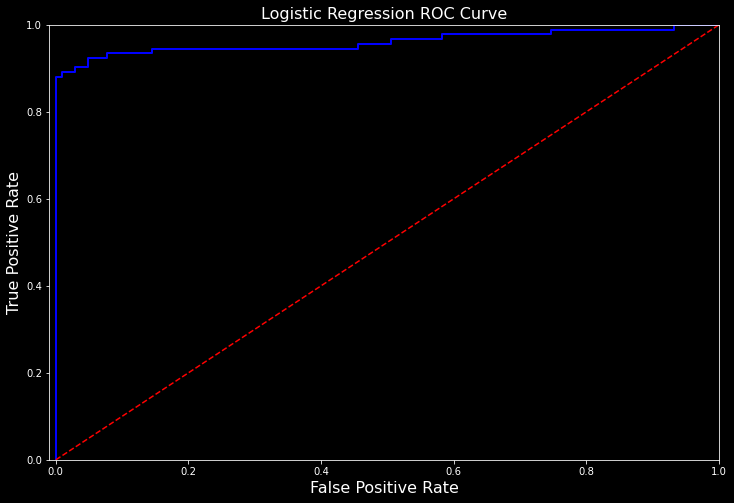

In [181]:
# Plot roc
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

logistic_roc_curve(log_fpr, log_tpr)
plt.show()

**Precision Recall Curve**

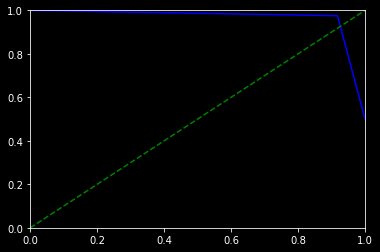

In [187]:
from sklearn.metrics import precision_recall_curve

# cal
log_train_preds = log_reg.predict(X_train)
precision, recall, threshold = precision_recall_curve(y_train, log_train_preds)

plt.plot(recall, precision, 'b-')
plt.plot([0,1], [0,1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


In [191]:
precision

array([0.5006435 , 0.97540984, 1.        ])

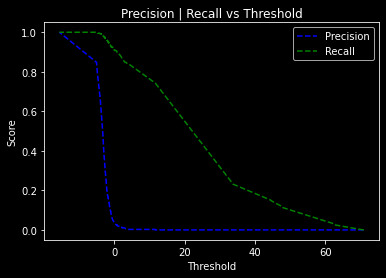

In [195]:
# y scores
y_scores = cross_val_predict(log_reg, X_train, y_train, method="decision_function")

# fpr and tpr
log_fpr, log_tpr, threshold = roc_curve(y_train, y_scores)

plt.title("Precision | Recall vs Threshold")
plt.plot(threshold, log_fpr, 'b--', label="Precision")
plt.plot(threshold, log_tpr, 'g--', label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

<h4>Using model to predict Fraud from original dataset</h4>

In [198]:
# training
y_train_original_preds = cross_val_predict(
    estimator=log_reg, 
    X=original_X_train, 
    y=original_y_train, cv=5, 
    method="decision_function"
)

# test
y_test_original_preds = cross_val_predict(
    estimator=log_reg, 
    X=original_X_test, 
    y=original_y_test, cv=5, 
    method="decision_function"
)


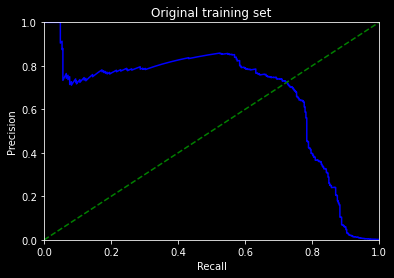

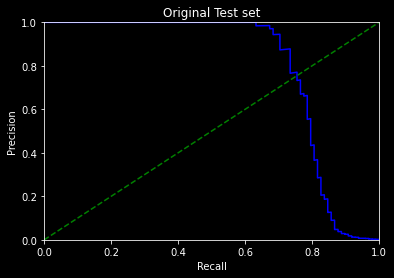

In [200]:
# train precision recall curve
precision, recall, threshold_otrain = precision_recall_curve(original_y_train, y_train_original_preds)
plt.plot(recall, precision, 'b-')
plt.plot([0,1], [0,1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Original training set")
plt.show();

precision, recall, threshold_otest = precision_recall_curve(original_y_test, y_test_original_preds)
plt.plot(recall, precision, 'b-')
plt.plot([0,1], [0,1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Original Test set")
plt.show()

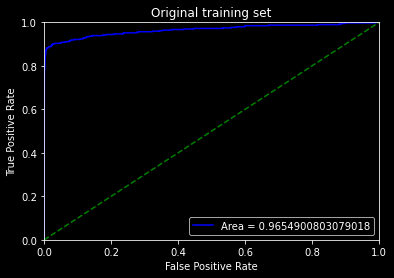

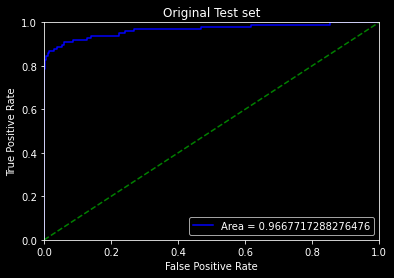

In [205]:
# train precision recall curve
fpr, tpr, threshold_otrain = roc_curve(original_y_train, y_train_original_preds)
plt.plot(fpr, tpr, 'b-', label=f"Area = {roc_auc_score(original_y_train, y_train_original_preds)}")
plt.plot([0,1], [0,1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Original training set")
plt.legend()
plt.show();

fpr, tpr, threshold_otest = roc_curve(original_y_test, y_test_original_preds)
plt.plot(fpr, tpr, 'b-', label=f"Area = {roc_auc_score(original_y_test, y_test_original_preds)}")
plt.plot([0,1], [0,1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Original Test set")
plt.legend()
plt.show()

Classification report:

In [208]:
# training
y_train_original_preds = cross_val_predict(
    estimator=log_reg, 
    X=original_X_train, 
    y=original_y_train, cv=5
)

# test
y_test_original_preds = cross_val_predict(
    estimator=log_reg, 
    X=original_X_test, 
    y=original_y_test, cv=5,
)

print("Original training report:")
print(classification_report(original_y_train, y_train_original_preds))
print("\nOrigianl Test data report: ")
print(classification_report(original_y_test, y_test_original_preds))


Original training report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227452
           1       0.81      0.58      0.68       394

    accuracy                           1.00    227846
   macro avg       0.90      0.79      0.84    227846
weighted avg       1.00      1.00      1.00    227846


Origianl Test data report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.73      0.80        98

    accuracy                           1.00     56961
   macro avg       0.94      0.87      0.90     56961
weighted avg       1.00      1.00      1.00     56961



<h3>SMOTE</h3>

**Understanding SMOTE**:

- Solving the Class Imbalance: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.
- Location of the synthetic points: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.
- Final Effect: More information is retained since we didn't have to delete any rows unlike in random undersampling.
- Accuracy || Time Tradeoff: Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

**Cross Validation Overfitting Mistake**:

*Overfitting during Cross Validation*:

In our undersample analysis I want to show you a common mistake I made that I want to share with all of you. It is simple, if you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. In the following section you will see amazing precision and recall scores but in reality our data is overfitting!

*The Wrong Way*:

<a align="center"><img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"></a>

As mentioned previously, if we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process. Remember how cross validation works, let's assume we are splitting the data into 5 batches, 4/5 of the dataset will be the training set while 1/5 will be the validation set. The test set should not be touched! For that reason, we have to do the creation of synthetic datapoints "during" cross-validation and not before, just like below:

*The right way*:

<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.




**References**: 
<ul>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation"> 
DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION </a></li> 

<li> <a src="http://rikunert.com/SMOTE_explained "> SMOTE explained for noobs  </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
</ul>